# HW3

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('deep')
sns.set_color_codes('deep')
sns.set_context('paper')
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

## Problem 1: Linear Regression Class [40pts]

### Part 1: Base Class

In [225]:
class Regression(object):
    
    def __init__(self):
        self.params = {}
    
    def get_params(self):
        # return best fit params (B-hat) from fit()
        return self.params
    
    def set_params(self, **kwargs):
        """Set params in subclass"""
        raise NotImplementedError
    
    def fit(self, X, y):
        # fits linear model supplied from subclass to X and y 
        # and stores best fit coeffs (b_hat) in params dict
        """Fit model in subclass"""
        raise NotImplementedError
    
    def predict(self, X):
        # get best fit coeffs from params dict and convert to column vector
        beta = self.params
        beta = np.concatenate(([beta['intercept']], beta['coeffs']))
        beta = np.array([beta]).T # convert to column vector
        
        # prepend the column of ones to design matrix
        nrows = X.shape[0]
        intercept_ones = np.ones(nrows)
        X = np.column_stack((intercept_ones, X))
        
        # y = X B + epsilon
        y_pred = X.dot(beta)
        y_pred = y_pred.T[0] # convert back to 1D array R_sq
        return y_pred
            
    def score(self, X, y):
        y_pred = self.predict(X)

        # score statistics
        y_bar = np.mean(y)
        SS_E = np.sum((y - y_pred)**2)
        SS_T = np.sum((y - y_bar)**2)
        R_sq = 1 - SS_E / SS_T
        return(R_sq)
    
    def plot_prediction(self, ax, y_pred, y_test):
        ax.plot(y_pred, 'r', label='prediction') # prediction
        ax.plot(y_test, 'b', label='test') # test
        ax.legend(loc='best')
        return ax

### Part 2: OLS Linear Regression

In [226]:
class LinearRegression(Regression):
    
    def __init__(self):
        self.M = 0
        super().__init__() # to maintain access to params dict
        
    def fit(self, X, y):
        # create design matrix (padding with ones column)
        if X.ndim == 1: # just duplicate the same observation
            X = np.insert(X, 0, 1)
            X = np.tile(X, (len(X), 1))
        else:
            num_rows = X.shape[0]
            intercept_ones = np.ones(num_rows)
            X = np.column_stack((intercept_ones, X))
        
        # compute B_hat
        X_inv = np.linalg.pinv(X)
        y = np.array([y]).T # convert to column vector
        B_hat = np.linalg.pinv(X.T.dot(X) + self.M).dot(X.T).dot(y)
        
        # return params
        B_hat = B_hat.ravel() # convert to 1D array
        self.params['coeffs'] = B_hat[1:]
        self.params['intercept'] = B_hat[0]

### Part 3: Ridge Regression

In [227]:
class RidgeRegression(LinearRegression):
    def __init__(self, alpha=0.1):
        super().__init__() # get access to params dict
        self.alpha = alpha
        self.M = self.ridge_mod()
        
    def ridge_mod(self): 
        # modifies Bhat calculation done in OLS
        
        # Gamma = alpha * I
        # The +1 accounts for extra column of 1's to give I the right dimensions
        Gamma = self.alpha*np.identity(len(X.T.dot(X)) + 1)
        return Gamma.T.dot(Gamma)  # overwrite default OLS M=0
    
    def set_params(self, **kwargs):
        self.alpha = kwargs['alpha']
        self.M = self.ridge_mod() # update

### Part 4: Model Scoring

#### Import the data

In [228]:
from sklearn import datasets
dataset = datasets.load_boston()

#### Poke around inside

In [229]:
# just looking at everything stored inside the dict
for k, v in dataset.items():
    print(f"{k} {np.shape(v)}:\n")

data (506, 13):

target (506,):

feature_names (13,):

DESCR ():



In [230]:
print(dataset['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

The dataset description in `dataset['DESCR']` tells us that there are 14 columns, but there are only 13 in `dataset.data` according to its shape though. This means that the 14th column is probably stored in the only other key whose value is a 1-D array, `dataset['target']` . This is also noted as "Median Value (attribute 14) is usually the target" in the `DESCR` field. I'll just tack this on to the end of the 2-D array and display it as a `pandas` DataFrame.

In [231]:
import pandas as pd
pd.options.display.max_rows = 10 # reduce how many rows are shown

# I'm not using dot notation to access data and feature names because I am pretending that dataset is a dict and not an sklearn object for this HW.
X = dataset['data']
y = dataset['target']
col_names = dataset['feature_names']
df = pd.DataFrame(X, columns=col_names)
df['target'] = y
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Ok, so it looks like each row is the stats for a town (or collection of homes?) and each column are some corresponding stats, with the last one being the median price in that particular  town in the  $1000's$.  

Recasting this as a linear regression problem: for any given town $i$, $y_i$ is the observed target median price corresponding to homes in that town and $x_{ij}$ is the $j$th statistic that was also measured for town $i$, corresponding to the $j$th column in row $i$ of the table shown above. For the $p$ regressors (number of columns, not including the target column), 

\begin{align}
    y_i = \sum_{j=0}^{p} x_{ij}\beta_j + \epsilon_i\ , 
    (i = 1,2,\dots, m)\ ,
\end{align}

where  $m$ is the number of towns (observations), $\beta_i$ is some scalar coefficient, $\epsilon_i$ is/are some unobserved random variable/s that account for influences on $y_i$ other than the collection of regressors $x_i$ that we happen to know about. Setting $x_{i0} = 1$ allows $(\beta_0)$ to act  as our intercept. In matrix form, all of the $m$ models (number of rows in the table) can compactly be written as
\begin{align}
    \boldsymbol y = \boldsymbol X \boldsymbol\beta + \boldsymbol\epsilon
    \ ,
\end{align}

where $\boldsymbol y$ is a column vector with length $m$, $\boldsymbol X$ is an $m\times n$ (design) matrix (where $n=p+1$, since it's just the data table above with a first column of ones and minus the target column), and $\boldsymbol\beta$ and $\boldsymbol\epsilon$ are also column  vectors of length $m$ composed of the $\beta_i$'s and $\epsilon_i$'s mentioned above. 

#### Game plan

Alright, I'm going to use the first 405 models ($\approx 80\%$ of the data) as my training set to determine the best fit coefficients $\boldsymbol{\hat\beta}$ found from OLS and Ridge to test on the reminaing 101 models, respectively, and score how well each predictive model does on the remaing 101 models in predicting the target housing price $y_i$.

In [232]:
def train_test_split(data, target, f=0.2, shuffle=False):
    # splits data into training and test set
    
    if shuffle:
        X_y = np.c_[data, target] 
        np.random.shuffle(X_y)
        data, target = X_y[:,:-1], X_y[:,-1]
        
    num_train = int(round((1-f)*len(X))) # number of training models
    
    # training set
    X_train = data[0:num_train, :]
    y_train = target[0:num_train]
    
    # test set
    X_test = data[num_train:, :]
    y_test = target[num_train:]
    return X_train, X_test, y_train, y_test

# train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    f=0.2, shuffle=True)

# run fits and display info in table
alpha = 0.1 # for Ridge
width = 50 # number of dashed lines in output

models = [LinearRegression(), RidgeRegression(alpha)]
model_names, y_preds, Rs = [], [], []
for model in models:
    model_name = model.__class__.__name__
    model_names.append(model_name)
    print(f"Stats for: {model_name}")
    print("-"*width)
    model.fit(X_train, y_train)
    y_preds.append(model.predict(X_test)) # for plotting
    score = model.score(X_test, y_test)
    Rs.append(score)
    beta = model.get_params()
    print(f"R^2: {score}\n")
    
    print("(Regressor coefficients):")
    for regressor, coeff in zip(col_names, beta['coeffs']):
        print(f"{regressor}: {coeff}")
    
    print(f"\nIntercept: {beta['intercept']}\n\n")

Stats for: LinearRegression
--------------------------------------------------
R^2: 0.7957093315789889

(Regressor coefficients):
CRIM: -0.12552456318534622
ZN: 0.04694962925819041
INDUS: 0.05259518929544209
CHAS: 2.1366654349818557
NOX: -19.006449769553576
RM: 3.5270608105793784
AGE: 0.006060557834806701
DIS: -1.4243389912348778
RAD: 0.32723253280130854
TAX: -0.012398103659100046
PTRATIO: -0.9486472009594513
B: 0.008157837111626605
LSTAT: -0.589003348392505

Intercept: 39.08750219303614


Stats for: RidgeRegression
--------------------------------------------------
R^2: 0.7960220296663164

(Regressor coefficients):
CRIM: -0.12534031752885016
ZN: 0.04703132460843138
INDUS: 0.051447800969918495
CHAS: 2.138348709541721
NOX: -18.64261708027518
RM: 3.558760107100741
AGE: 0.00582173905518019
DIS: -1.4149709492817837
RAD: 0.3250118852612101
TAX: -0.012361210301728386
PTRATIO: -0.9385648693915276
B: 0.008234383679230626
LSTAT: -0.5876467754712429

Intercept: 38.452613061540674




As a quick sanity check, here is what the predicted vs actual housing price values look like for the test set for both linear regression models.

<IPython.core.display.Javascript object>


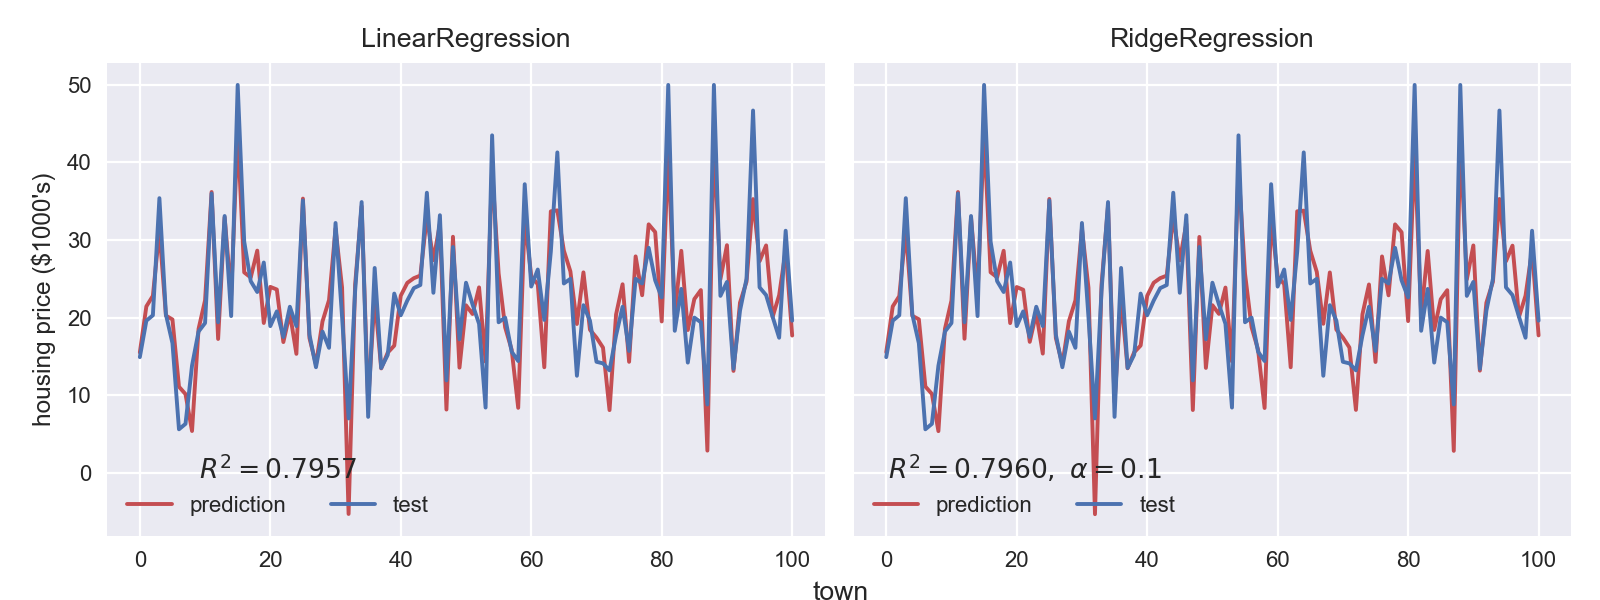

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

for ax, model_name, y_pred, R in zip(axes, model_names, y_preds, Rs):
    ax = model.plot_prediction(ax, y_pred, y_test)
    ax.set_title(model_name)

    if model_name == 'LinearRegression':
        leg_title = f'$R^2 = {R:.4f}$'
    else:
        leg_title = f'$R^2 = {R:.4f},\ \\alpha={alpha}$'

    ax.legend(loc='best', ncol=2, title=leg_title)

axes[0].set_ylabel("housing price ($1000's)")
fig.text(0.508, 0, "town")
fig.tight_layout()

### Part 5: Visualize Model Performance

<IPython.core.display.Javascript object>


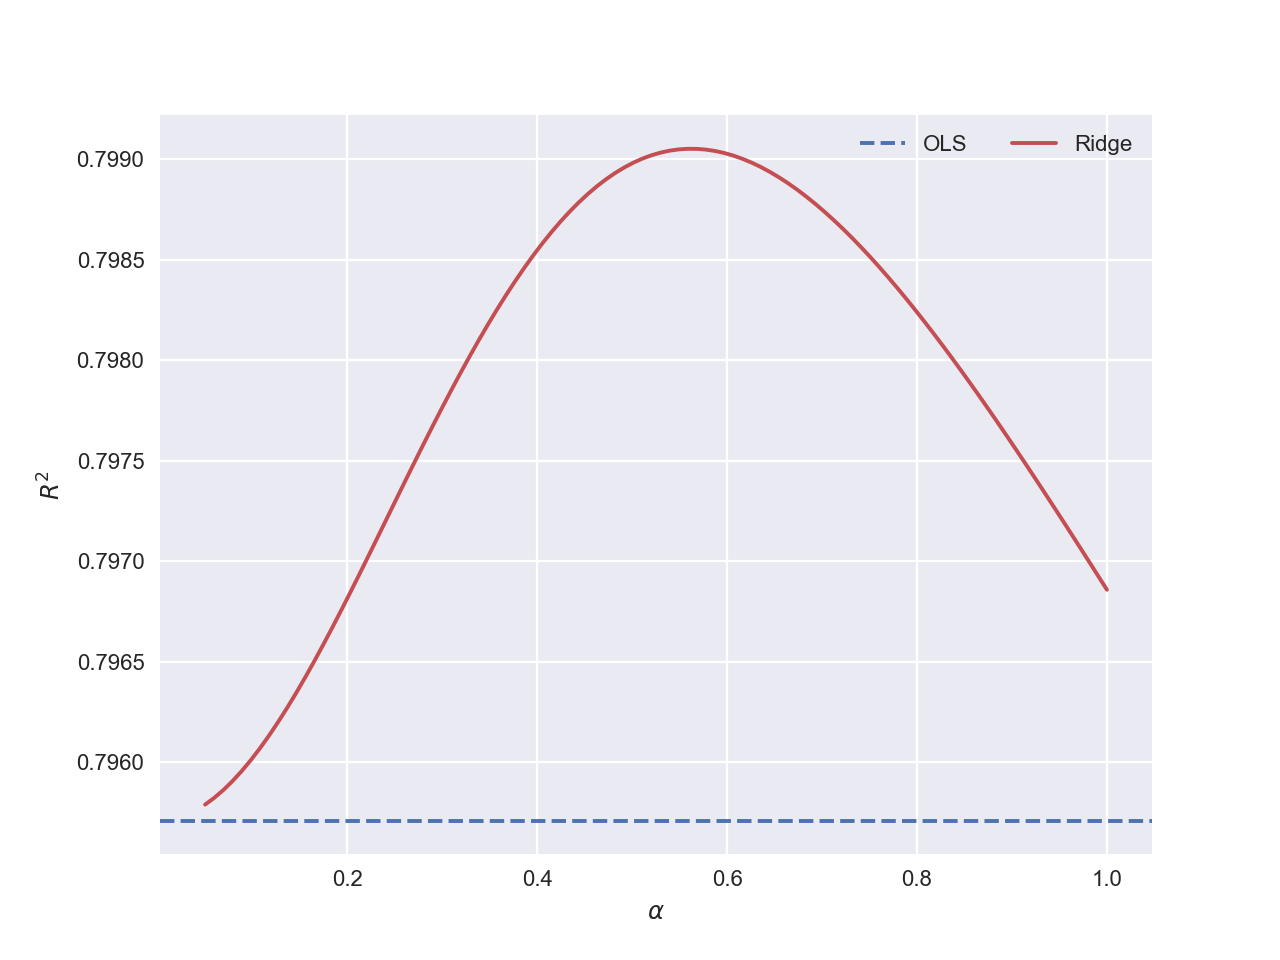

Text(0,0.5,'$R^2$')

In [234]:
# get OLS score
model = LinearRegression()
model.fit(X_train, y_train)
score_OLS = model.score(X_test, y_test)

# get Ridge scores
alphas = np.linspace(0.05, 1, 100)
scores_ridge = []
for alpha in alphas:
    model = RidgeRegression()
    model.set_params(alpha=alpha) # update default alpha=0.1
    model.fit(X_train, y_train)
    score_ridge = model.score(X_test, y_test)
    scores_ridge.append(score_ridge)
    
# plot
fig, ax = plt.subplots()
ax.axhline(score_OLS, ls='--', label='OLS') # OLS
ax.plot(alphas, scores_ridge, 'r', label='Ridge') # Ridge
ax.legend(loc='best', ncol=2)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$R^2$')

## Problem 2 [10pts]

### Part 1: Create a module

Included in directory as `MathCS207.py`

### Part 2: Import a whole module and use it

In [48]:
import MathCS207

# inputs
inputs = {'a':1., 'b':2.}

# show output from module
print(
    f"inputs: {inputs}\n----------------------------\n"
    f"addition (a + b): {MathCS207.add(**inputs)}\n"
    f"subtraction (a - b): {MathCS207.subtract(**inputs)}\n"
    f"multiplication (a*b): {MathCS207.multiply(**inputs)}\n"
    f"division (a/b): {MathCS207.divide(**inputs)}"
)

inputs: {'a': 1.0, 'b': 2.0}
----------------------------
addition (a + b): 3.0
subtraction (a - b): -1.0
multiplication (a*b): 2.0
division (a/b): 0.5


### Part 3: Import a single function from a module and use it

In [49]:
from MathCS207 import add

print(add(**inputs))

3.0


### Part 4: Import a module by creating an alias of it and then use the alias

In [50]:
import MathCS207 as mathcs

print(mathcs.add(**inputs))

3.0


### Part 5: List every function definition inside the module MathCS207

In [52]:
print(dir(MathCS207))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'add', 'divide', 'multiply', 'subtract']


## Problem 3: Bank Account Revisited [50pts]

#### Defining `SAVINGS` and `CHECKING` bank accounts

In [444]:
from enum import Enum
class AccountType(Enum):
    SAVINGS = 1
    CHECKING = 2

### Part 1: Create a BankAccount class

In [ ]:
class BankAccount():
    
    def __init__(self, owner, accountType):
        self.owner = owner
        self.accountType = accountType
        
    def withdraw(self, amount): 
        return 
    
    def deposit(self, amount):

### Part 2: Write a class BankUser

In [ ]:
class BankUser():
    
    def __init__(self, owner):
        self.owner = owner
    
    def addAccount(self, accountType):
        
    def getBalance(self, accountType):
    
    def deposit(self, accountType, amount): 
        
    def withdraw(self, accountType, amount):

In [76]:
def make_withdraw(balance):
    def update_balance(debit):
        # places the variable 'balance' in the outer scope of
        # make_withdraw 
        # into the inner scope of update_balance
        nonlocal balance
        if debit <= balance:
            balance -= debit
            print(f"New balance: ${balance:.2f}")
        else:
            print("Please enter a withdrawl amount " 
                  "less than or equal to your current balance.")
    return update_balance

init_balance = 500 # initial balance
withdraw_amount = 150.50 # amount to withdraw

wd = make_withdraw(init_balance)
wd(withdraw_amount)

New balance: $349.50
